In [1]:
import sys
sys.path.append('./../')
import shap
from typing import List, Union
import torch.nn.functional as F
from data.loader import DataLoader
import json
import random
import torch.backends.cudnn as cudnn
import numpy as np
import torch
import torch.nn as nn
from captum.attr import IntegratedGradients
from typing import Union

# Use SHAP to explain the static layer
https://shap-lrjball.readthedocs.io/en/latest/api.html#core-explainers

In [2]:
# load Conv1D and FC models
class CNN1dKernel(torch.nn.Module):
    def __init__(self, *, nInChannel=1, nKernel=3, kernelSz=3, stride=1, padding=0):
        super(CNN1dKernel, self).__init__()
        self.cnn1d = nn.Conv1d(in_channels=nInChannel, out_channels=nKernel, kernel_size=kernelSz, padding=padding,
                               stride=stride)

    def forward(self, x):
        output = F.relu(self.cnn1d(x))
        return output

def calConvSize(lin, kernel, stride, padding=0, dilation=1):
    lout = (lin + 2 * padding - dilation * (kernel - 1) - 1) / stride + 1
    return int(lout)


def calPoolSize(inLen, kernelSz, stride=None, padding=0, dilation=1):
    if stride is None:
        stride = kernelSz
    outLen = (inLen + 2 * padding - dilation * (kernelSz - 1) - 1) / stride + 1
    return int(outLen)


class FC(nn.Module):
    def __init__(self, inFC: int, ny: int, hidden: int, dropout: float = 0.5):
        super(FC, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(inFC, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, ny)
        )

    def forward(self, x):
        out = self.fc(x)
        return out


class Conv1D(nn.Module):
    def __init__(self, nz: int, inLen: int, nKernel: List[int], kernelSz: List[int],
                 stride: Union[List[int], None] = None, poolKerSz: Union[List[int], None] = None, dropout: float = 0.5):
        super(Conv1D, self).__init__()
        nLayer = len(nKernel)
        self.convLayers = nn.Sequential()
        inChan = nz  # need to modify the hardcode: 4 for smap and 1 for FDC
        outLen = inLen
        for i in range(nLayer):
            convLayer = CNN1dKernel(nInChannel=inChan, nKernel=nKernel[i], kernelSz=kernelSz[i], stride=stride[i])
            self.convLayers.add_module('CnnLayer%d' % (i + 1), convLayer)
            self.convLayers.add_module('Relu%d' % (i + 1), nn.ReLU())
            self.convLayers.add_module('dropout%d' % (i + 1), nn.Dropout(p=dropout))
            inChan = nKernel[i]
            outLen = calConvSize(lin=outLen, kernel=kernelSz[i], stride=stride[i])
            if poolKerSz[i] is not None:
                self.convLayers.add_module('Pooling%d' % (i + 1), nn.MaxPool1d(poolKerSz[i]))
                outLen = calPoolSize(inLen=outLen, kernelSz=poolKerSz[i])

    def forward(self, x):
        forcing, attrs = x[:, :, :5], x[:, :, 5:]
        encoded = self.convLayers(forcing.permute(0, 2, 1))
        out = torch.cat((encoded.squeeze(1), attrs[:, -1, :]), dim=-1)
        return out

In [3]:
# get model configuration and training results
folder = '../checkpoints/seed_668823_nMul_16_wMul_True_nOut_3_wLAI_0.5_snow_NN_False_model_type_EXP-BGM_t_0324-2303'
with open(f'{folder}/config.json', 'r') as f:
    config = json.load(f)

# fix random seed
seed = config['train']['seed']
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False

# get dataloaders
device = torch.device('cuda:0' if config['train']['gpu'] and torch.cuda.is_available() else 'cpu')
loader = DataLoader(xdataFile='../'+config['data']['xDataFile'], flowFile='../'+config['data']['flowFile'],
                    laiFile='../'+config['data']['laiFile'], periods=config['data']['periods'],
                    spinUp=config['data']['spinUp'], seqLen=config['data']['seqLen'],
                    winSize=config['data']['winSz'], device=device,
                    hydStation=config['data']['hydStations'], excludeBsnAttrVar=config['data']['excludeBsnAttrVar'])

# load model
staSz = [config['staNet']['nAttr'], config['staNet']['nMet'], config['staNet']['hidFC'],
         config['staNet']['outFC'], config['staNet']['lenMet'], config['staNet']['nKernel'],
         config['staNet']['kernelSz'], config['staNet']['stride'], config['staNet']['poolSz']]
nAttr, nMet, hidFC, outFC, lenMet, nKernel, kernelSz, stride, poolSz = staSz
nMul, wMul = config['train']['nMul'], config['train']['wMul']
outFC = (outFC - 2) * nMul + 2 + nMul if wMul else (outFC - 2) * nMul + 2  # 2 means two hillslope routing parameters

conv1d = Conv1D(nz=nMet, inLen=lenMet, nKernel=nKernel, kernelSz=kernelSz, stride=stride, poolKerSz=poolSz, dropout=0.5)
conv1d = conv1d.to(device)
fc = FC(inFC=125, ny=outFC, hidden=hidFC, dropout=0.5)
fc = fc.to(device)

# load model weights
pretrained_model = torch.load(f'{folder}/model.pt', map_location=device)
conv1d_state_dict, fc_state_dict = conv1d.state_dict(), fc.state_dict()
for name, param in pretrained_model.items():
    if name[7:] in conv1d_state_dict.keys():
        conv1d_state_dict[name[7:]].copy_(param)
    elif name[7:] in fc_state_dict.keys():
        fc_state_dict[name[7:]].copy_(param)

In [4]:
# prepare input data for FC
xn = loader.loaderTst.dataset.xn.squeeze(0)
bsnAttr = loader.loaderTst.dataset.bsnAttr
z = torch.cat((xn, bsnAttr.unsqueeze(1).repeat(1, xn.size(1), 1)), dim=-1)
staIdx=config['data']['spinUp'][0]
X_test = conv1d(z[:, :staIdx, :])

In [5]:
# Use SHAP to explain the static layer
explainer = shap.DeepExplainer(fc, X_test)
shap_values = explainer.shap_values(X_test)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


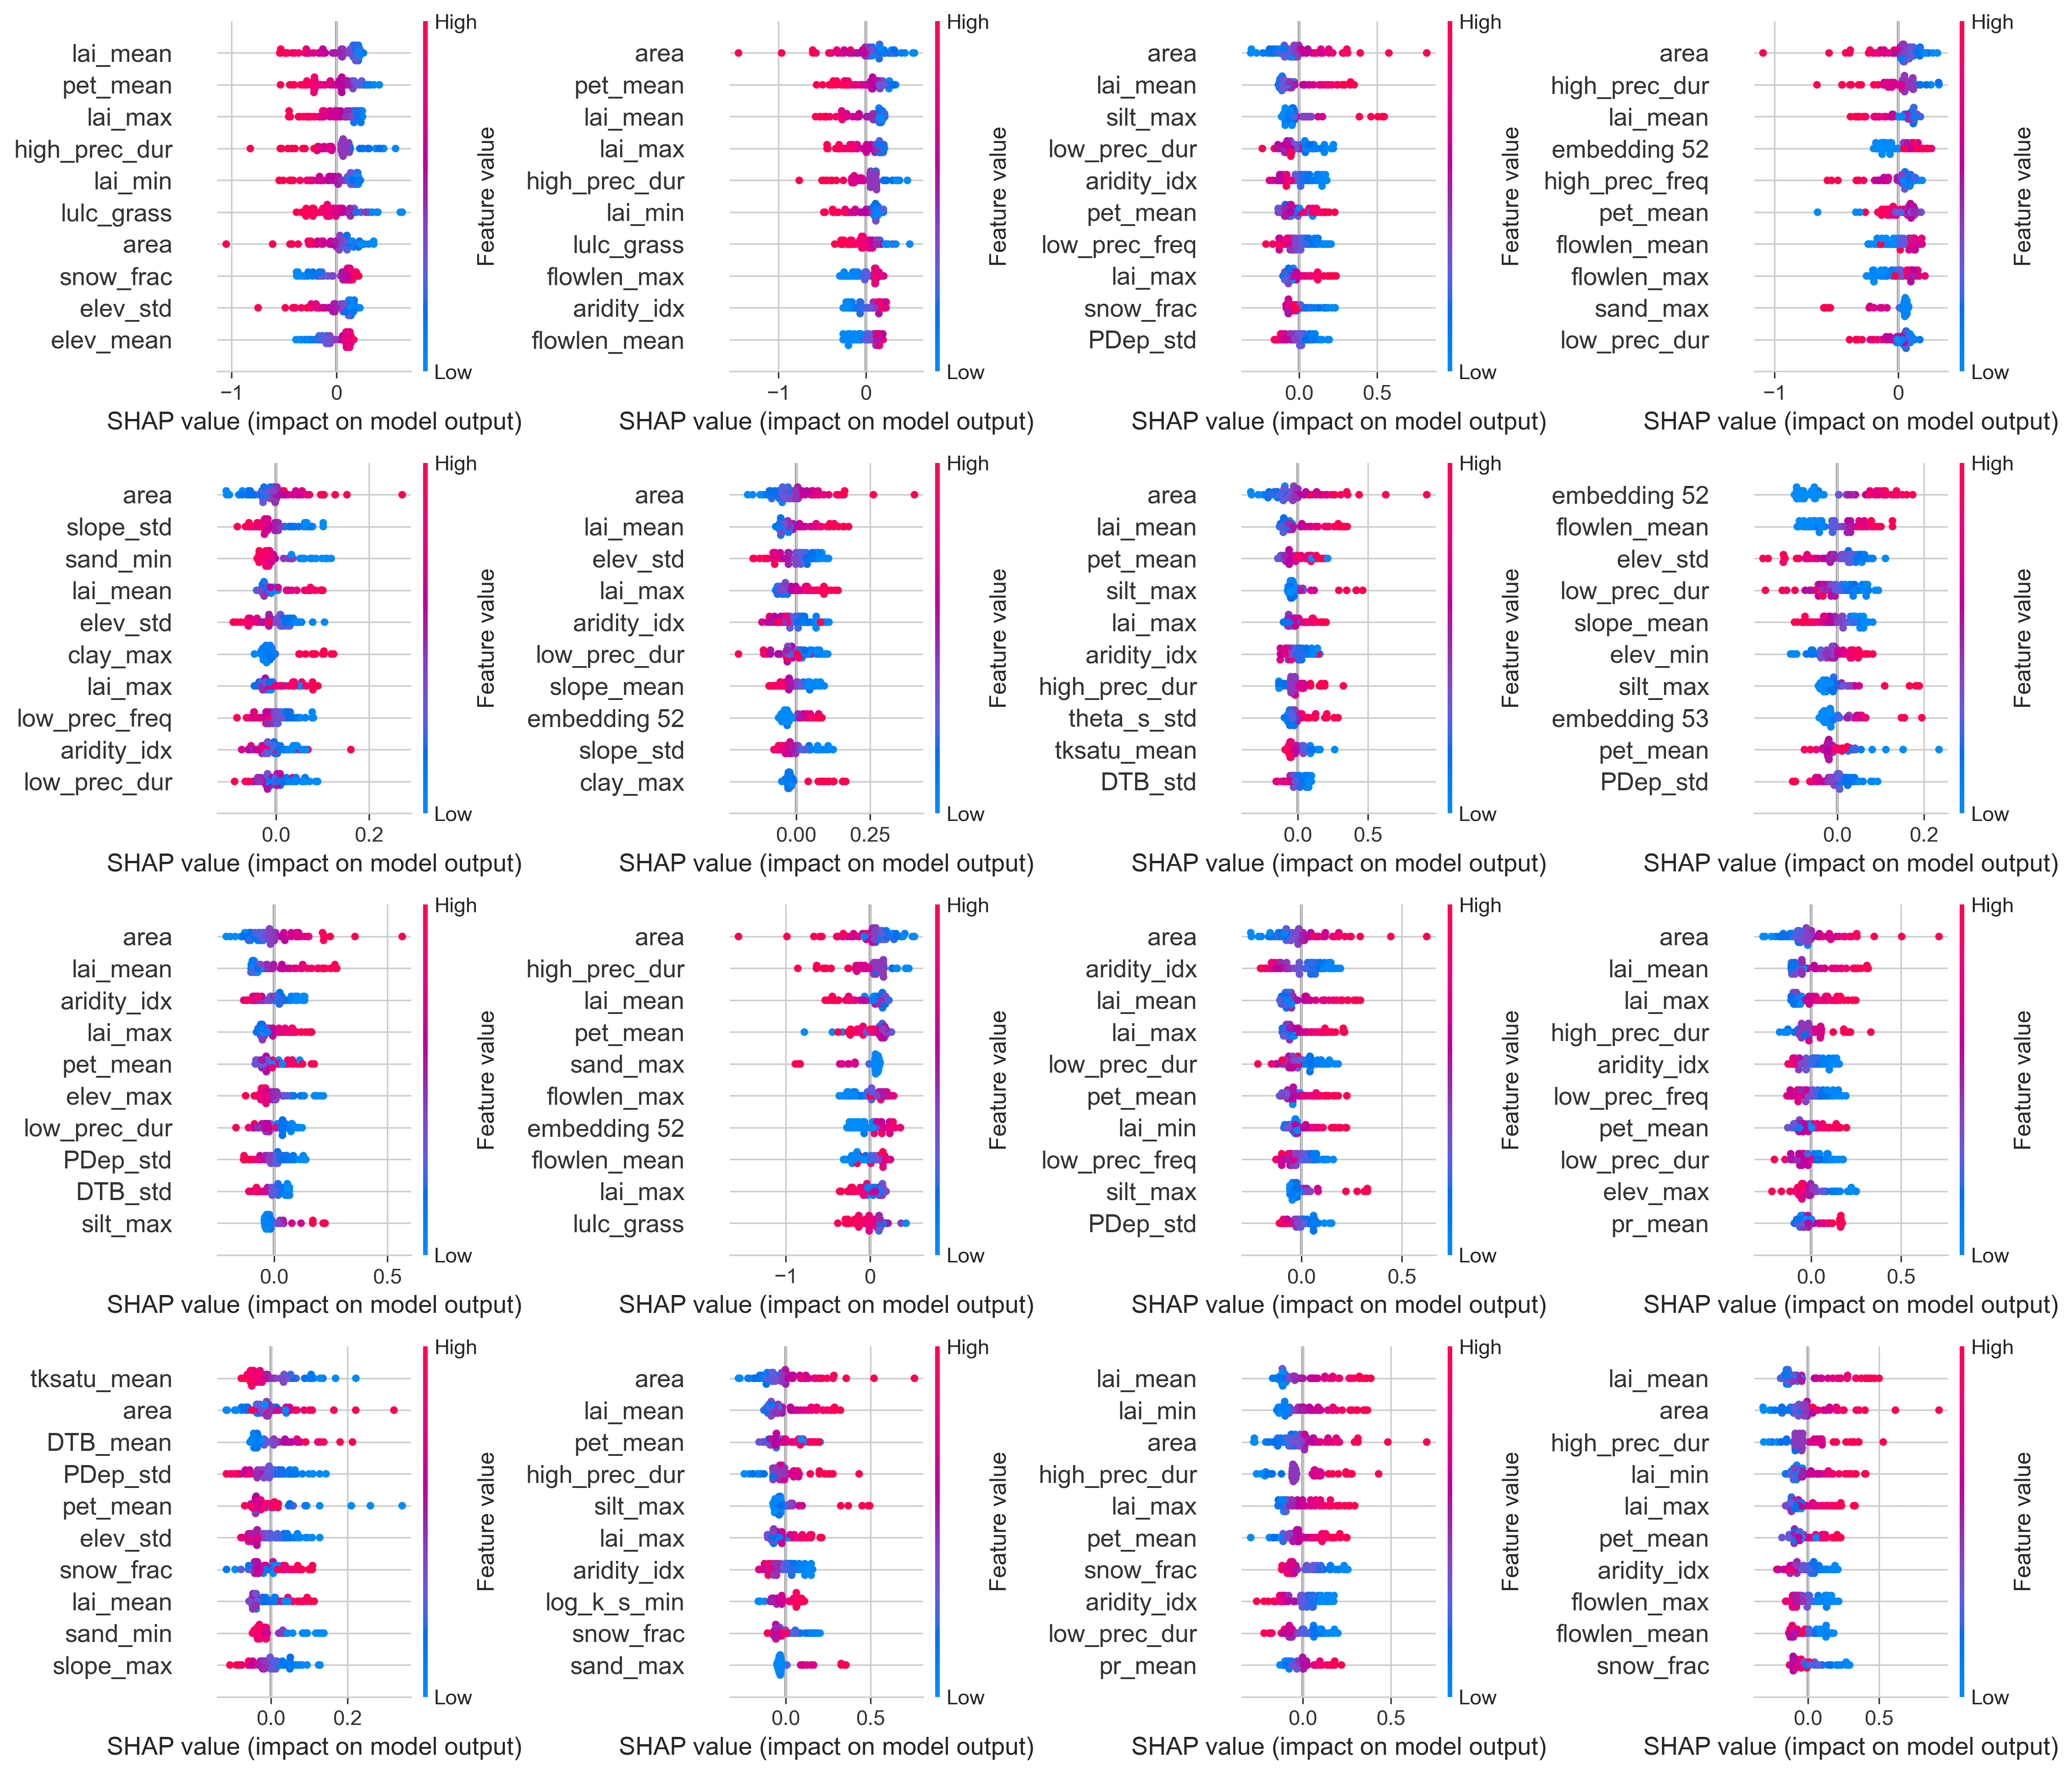

In [12]:
# determine which parameter to be explained
show_para = 'parKS'

import shap
import matplotlib.pyplot as plt
featureLst = [f'embedding {i}' for i in range(X_test.shape[1] - nAttr)] + loader.dataTst['bsnAttrVarLst']

num_static_para = config['staNet']['outFC'] - 2
nMul = config['train']['nMul']
static_paras = ['parTMIN', 'parDDF', 'parTMAX', 'parQMAX', 'parSMAX', 'parIMAX', 'parKS', 'parWUE', 'wMul'] if num_static_para == 8 else ['parTMIN', 'parDDF', 'parTMAX', 'parQMAX', 'parSMAX', 'parIMAX', 'parKS', 'wMul']
# idx_lst = range(static_paras.index(show_para) * nMul, static_paras.index(show_para) * nMul + nMul)
idx_lst = [static_paras.index(show_para) + len(static_paras) * mul for mul in range(nMul)]
# # get simulation results and the weights of multi-components
# with open(os.path.join(f'{folder}', 'simulation.pkl'), 'rb') as f:
#     simulation = pickle.load(f)
# wMul = simulation['wMul']

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 13), dpi=300)
# axes =axes.flatten()
for num, idx in enumerate(idx_lst):
    ax = axes[num//4, num%4]
    shap_values_for_feature = shap_values[idx]
    shap.summary_plot(shap_values_for_feature, X_test.detach().cpu().numpy(), max_display=10, feature_names=featureLst, plot_type='dot', color=shap_values_for_feature, plot_size=None, show=False)
    plt.sca(ax)

    # ax.annotate(f'{chr(97+idx % 16)}. Component {idx % 16}', xy=(-0.4, 0.98), xycoords='axes fraction', fontsize=12)
fig.tight_layout()

In [13]:
ig = IntegratedGradients(fc)
for idx in idx_lst:
    attributions = ig.attribute(X_test, target=idx, n_steps=100)  # for the last timestep
    attributions = attributions.detach().cpu().numpy()

    importance_score = np.abs(attributions).mean(axis=0)
    var_5 = np.array(featureLst)[np.argsort(importance_score)[::-1][:5]]
    print(idx, var_5)

6 ['lai_mean' 'area' 'lai_max' 'lai_min' 'snow_frac']
14 ['lai_mean' 'high_prec_dur' 'lai_max' 'pet_mean' 'lulc_grass']
22 ['area' 'lai_mean' 'pet_mean' 'lai_max' 'high_prec_dur']
30 ['area' 'lai_mean' 'pet_mean' 'aridity_idx' 'low_prec_dur']
38 ['pet_mean' 'area' 'lai_mean' 'lai_max' 'flowlen_mean']
46 ['lai_max' 'area' 'aridity_idx' 'lai_min' 'low_prec_dur']
54 ['area' 'aridity_idx' 'pet_mean' 'low_prec_dur' 'lai_mean']
62 ['area' 'lai_mean' 'pet_mean' 'aridity_idx' 'snow_frac']
70 ['embedding 52' 'flowlen_mean' 'low_prec_dur' 'elev_std' 'slope_mean']
78 ['area' 'lai_mean' 'aridity_idx' 'pet_mean' 'low_prec_dur']
86 ['area' 'pet_mean' 'lai_mean' 'lai_max' 'high_prec_dur']
94 ['area' 'aridity_idx' 'lai_mean' 'lai_max' 'low_prec_dur']
102 ['area' 'lai_mean' 'lai_max' 'lai_min' 'pet_mean']
110 ['aridity_idx' 'low_prec_dur' 'lai_mean' 'pet_mean' 'area']
118 ['area' 'pet_mean' 'lai_mean' 'lai_max' 'high_prec_dur']
126 ['area' 'lai_mean' 'lai_min' 'lai_max' 'high_prec_dur']


# Use Integrated Gradients to explain the dynamic layer
https://captum.ai/api/integrated_gradients.html

In [14]:
class LSTM(nn.Module):
    def __init__(self, inLSTM: int, hidLSTM: int, device: Union[str, torch.device] = 'cpu'):
        super(LSTM, self).__init__()
        self.hidLSTM = hidLSTM
        self.device = device
        self.lstm = nn.LSTM(inLSTM, hidLSTM, device=device, batch_first=True)

    def forward(self, x, hidden=None):
        hidden = self.init_hidden(x.shape[0]) if hidden is None else hidden
        out = self.lstm(x, hidden)
        return out

    def init_hidden(self, bsz):
        # LSTM h and c
        h = torch.zeros((1, bsz, self.hidLSTM), dtype=torch.float32).to(self.device)
        c = torch.zeros((1, bsz, self.hidLSTM), dtype=torch.float32).to(self.device)
        return h, c

class DynParasLSTM(nn.Module):
    """
    Use LSTM to learn the dynamic parameters from forcing and attributes.
    """

    def __init__(self, inLSTM: int, hidLSTM: int, outLSTM: int, dropout: float = 0.5,
                 device: Union[str, torch.device] = 'cpu'):
        super(DynParasLSTM, self).__init__()
        self.device = device
        self.hidLSTM = hidLSTM

        self.fcIn = nn.Sequential(
            nn.Linear(inLSTM, hidLSTM),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.LSTM = LSTM(hidLSTM, hidLSTM, device=device)
        self.fcOut = nn.Linear(hidLSTM, outLSTM)

    def forward(self, x, hidden=None):
        """
        :param x: consists of forcing and attributes with a shape of [N, L, F]
        """
        x = self.fcIn(x)
        hidden = self.LSTM.init_hidden(x.shape[0]) if hidden is None else hidden
        x, hidden = self.LSTM(x, hidden)
        out = self.fcOut(x)
        return out

In [26]:
# load model
import pandas as pd
device = torch.device('cuda:0' if config['train']['gpu'] and torch.cuda.is_available() else 'cpu')
lstm = DynParasLSTM(inLSTM=config['dynNet']['inLSTM'], hidLSTM=config['dynNet']['hidLSTM'], outLSTM=config['dynNet']['outLSTM'] * nMul, device=device)
lstm_state_dict = lstm.state_dict()
for name in lstm_state_dict.keys():
    if f'dynNet.{name}' in pretrained_model.keys():
        print(f'{name} matches successfully!')
        lstm_state_dict[name].copy_(pretrained_model[f'dynNet.{name}'])
    else:
        print(f'{name} does not match!')
lstm = lstm.to(device)

# load data
xn = loader.loaderTst.dataset.xn.squeeze(0)
bsnAttr = loader.loaderTst.dataset.bsnAttr
X_test = torch.cat((xn, bsnAttr.unsqueeze(1).repeat(1, xn.size(1), 1)), dim=-1)
dates = pd.date_range(start=loader.dataTst['tRange'][0] - pd.Timedelta(days=365), end=loader.dataTst['tRange'][-1])[:1825]

# get simulation results and the weights of multi-components
import os
import pickle
with open(os.path.join(f'{folder}', 'simulation.pkl'), 'rb') as f:
    simulation = pickle.load(f)
wMul = simulation['wMul']
X_test = X_test[1:2, :1825, :].to(device)
wMul = wMul[1, :]

fcIn.0.weight matches successfully!
fcIn.0.bias matches successfully!
LSTM.lstm.weight_ih_l0 matches successfully!
LSTM.lstm.weight_hh_l0 matches successfully!
LSTM.lstm.bias_ih_l0 matches successfully!
LSTM.lstm.bias_hh_l0 matches successfully!
fcOut.weight matches successfully!
fcOut.bias matches successfully!


You have mixed positional and keyword arguments, some input may be discarded.


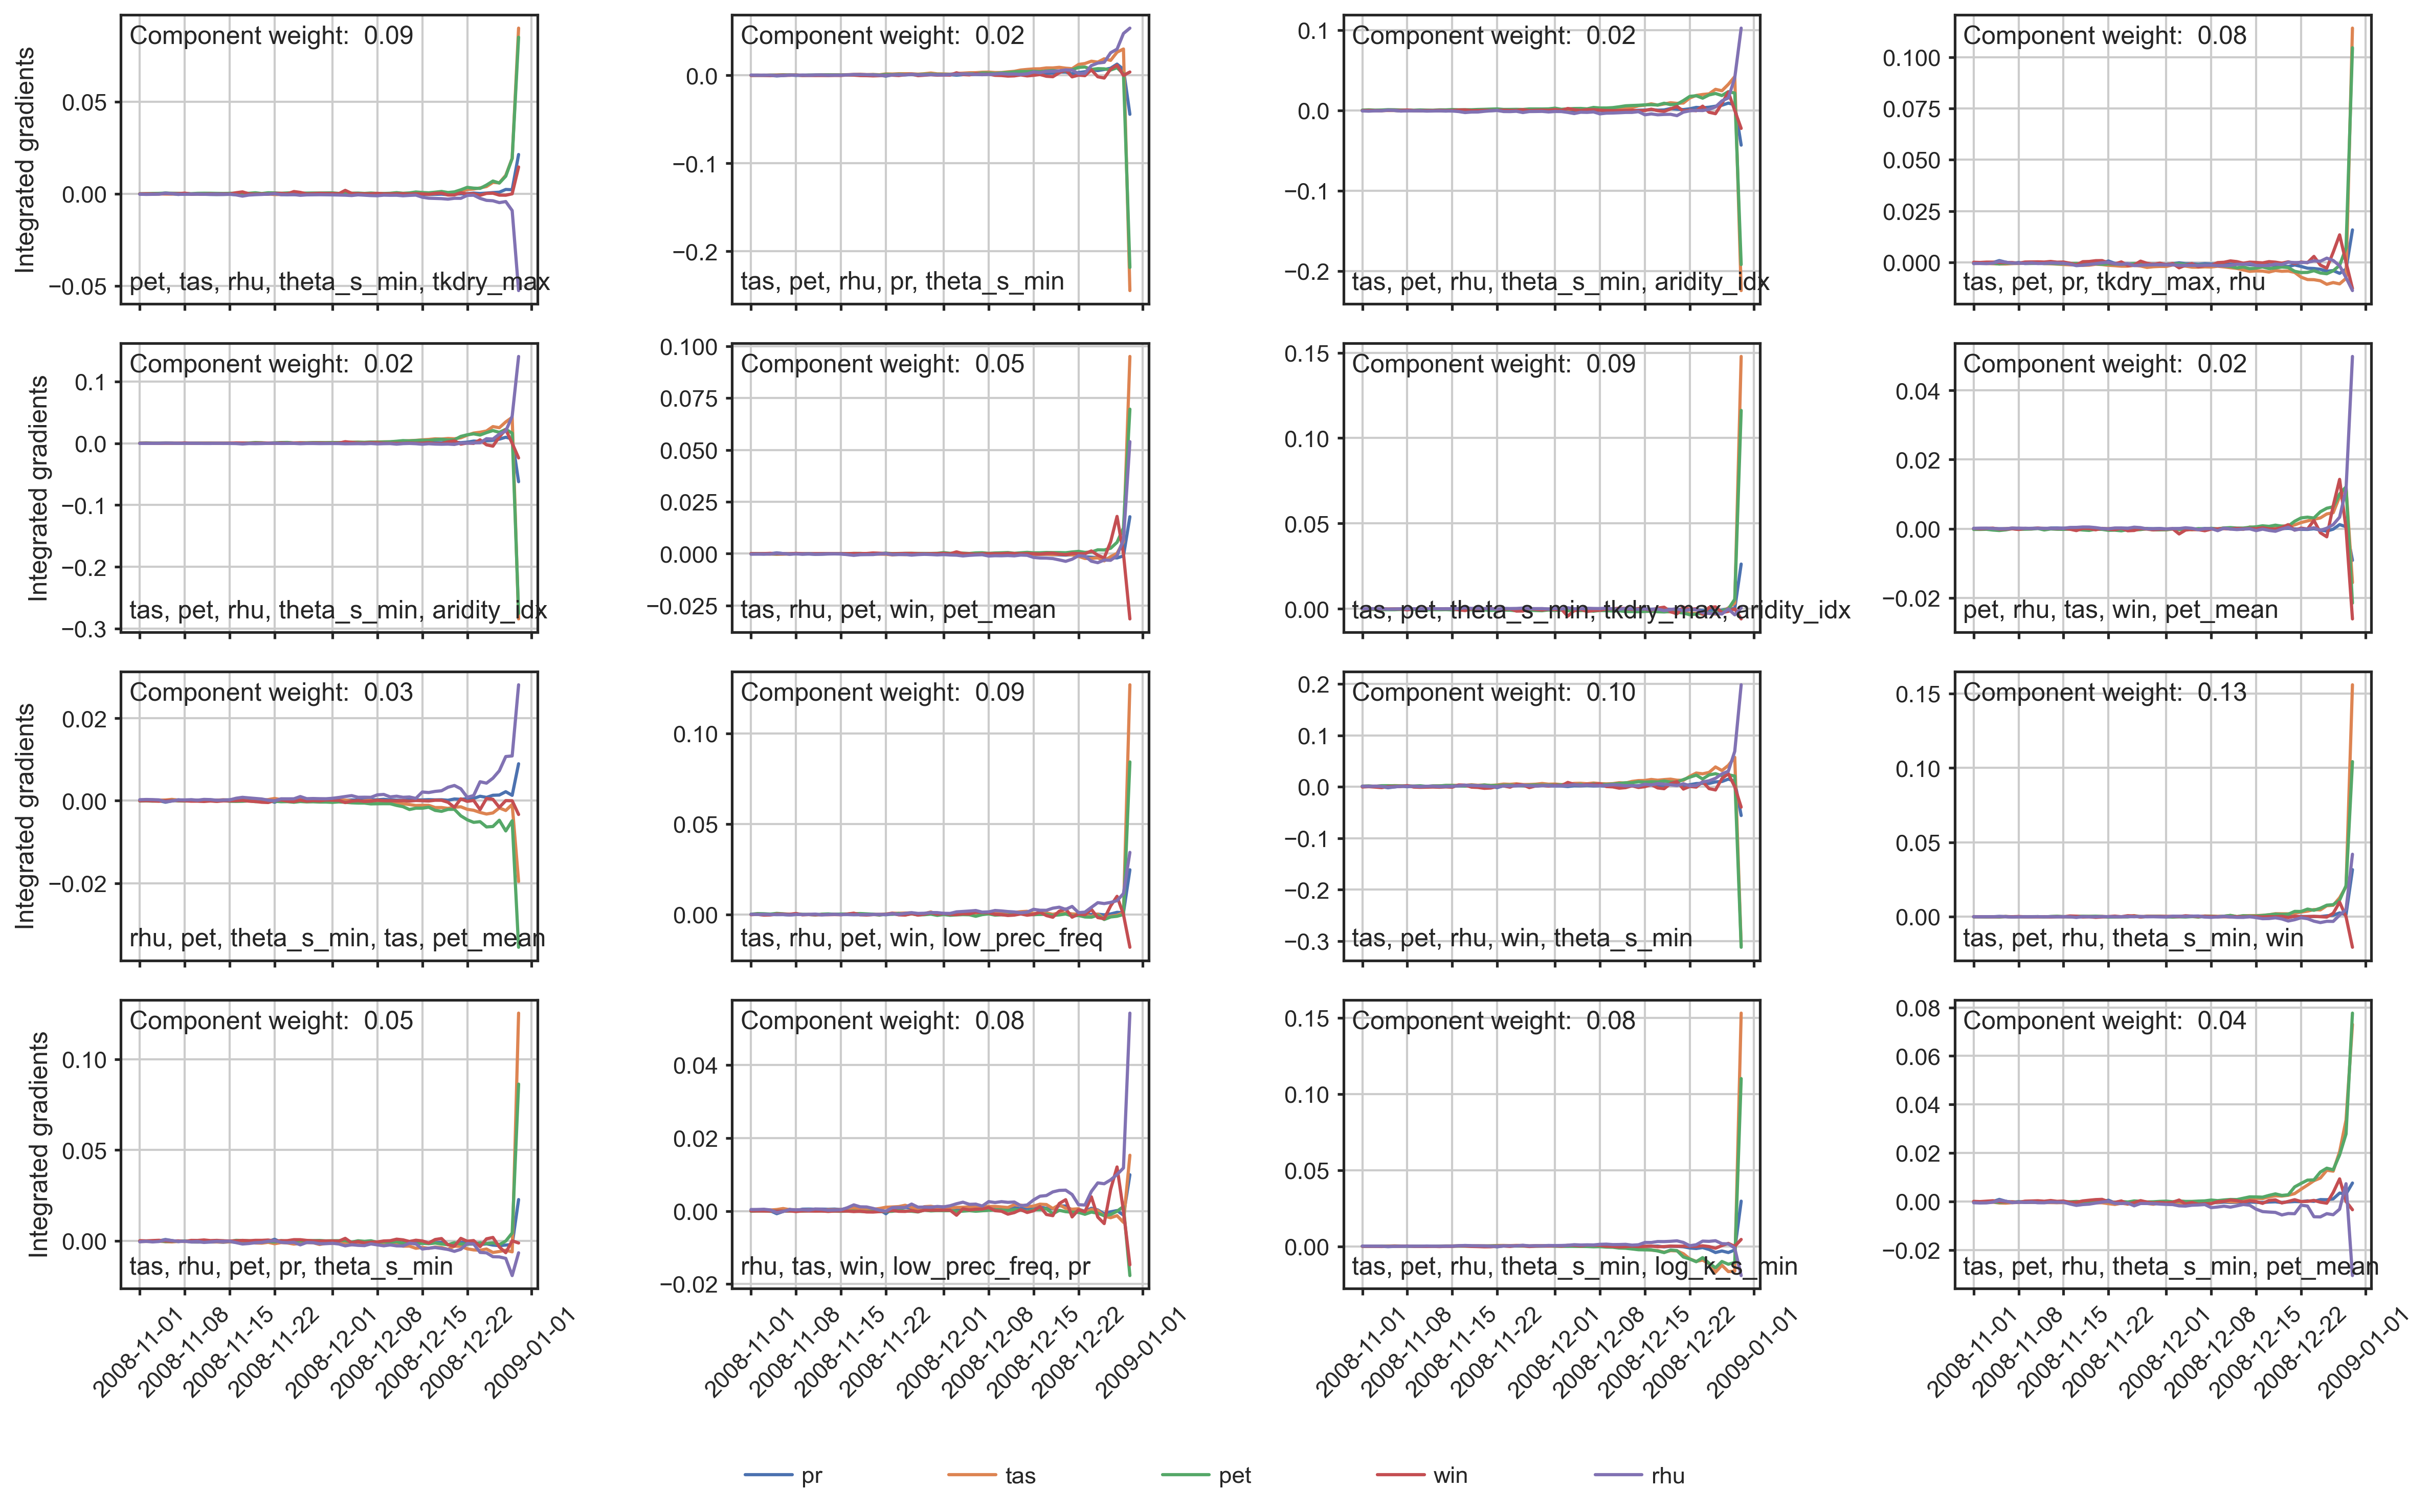

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {
    # 'axes.spines.right': False,
    # 'axes.spines.top': False,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
}
sns.set_theme(style='ticks', rc=custom_params)

# determine which parameter to be explained
para = 'parWUE'
dyn_paras = ['parF', 'parALPHA', 'parRSUB', 'parKsg', 'parWUE'] if config['dynNet']['outLSTM'] == 5 else ['parF', 'parALPHA', 'parRSUB', 'parKsg']

# Use Integrated Gradients to explain the dynamic layer
ig = IntegratedGradients(lstm)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 10), dpi=300)
axes = axes.flatten()
varLst = loader.dataTst['forVarLst'] + loader.dataTst['bsnAttrVarLst']

for mul in range(0, nMul):
    # Use Captum to calculate Integrated Gradients
    # target is a tuple containing the index of the last two dimensions
    attributions = ig.attribute(X_test, target=(-1, dyn_paras.index(para) + len(dyn_paras) * mul), n_steps=100)  # for the last timestep
    # attributions = ig.attribute(X_test, target=(-1, dyn_paras.index(para) * nMul + mul), n_steps=100)  # for the last timestep
    attributions = attributions.cpu().numpy()

    idx = 60  # window of back sight
    # calculate the cumulative absolute ig during the back sight window
    ig_window = np.abs(attributions[0, -idx:]).sum(axis=0)
    var_5 = np.array(varLst)[np.argsort(ig_window)[::-1][:5]]
    # print(f'The most important 5 variables for component {mul+1} are {var_5}')

    ax = axes[mul]
    for i in range(0, 5):
        ax.plot(dates[-idx:], attributions[0, -idx:, i], label=loader.dataTst['forVarLst'][i])
    if mul % 4 == 0:
        ax.set_ylabel('Integrated gradients')
    if mul < 12:
        ax.set_xticklabels([])

    ax.tick_params(rotation=45, axis='x')
    ax.grid(True)
    text = ''
    for var in var_5:
        text += f'{var}, '
    ax.annotate(text[:-2], xy=(0.02, 0.05), xycoords='axes fraction')
    ax.annotate(f'Component weight: {wMul[mul]: .2f}', xy=(0.02, 0.9), xycoords='axes fraction')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels=labels, ncol=5, handletextpad=0.4, bbox_to_anchor=(0.3, 0.03, 0.4, 0.02), mode='expand', columnspacing=1, frameon=False)

fig.tight_layout(rect=(0, 0.06, 1, 1))
plt.show()

# Use SHAP expexted gradients to explain the dynamic layer

In [30]:

class LSTM(nn.Module):
    def __init__(self, inLSTM: int, hidLSTM: int, device: Union[str, torch.device] = 'cpu'):
        super(LSTM, self).__init__()
        self.hidLSTM = hidLSTM
        self.device = device
        self.lstm = nn.LSTM(inLSTM, hidLSTM, device=device, batch_first=True)

    def forward(self, x, hidden=None):
        hidden = self.init_hidden(x.shape[0]) if hidden is None else hidden
        out = self.lstm(x, hidden)
        return out

    def init_hidden(self, bsz):
        # LSTM h and c
        h = torch.zeros((1, bsz, self.hidLSTM), dtype=torch.float32).to(self.device)
        c = torch.zeros((1, bsz, self.hidLSTM), dtype=torch.float32).to(self.device)
        return h, c

class DynParasLSTM(nn.Module):
    """
    Use LSTM to learn the dynamic parameters from forcing and attributes.
    """

    def __init__(self, inLSTM: int, hidLSTM: int, outLSTM: int, dropout: float = 0.5,
                 device: Union[str, torch.device] = 'cpu'):
        super(DynParasLSTM, self).__init__()
        self.device = device
        self.hidLSTM = hidLSTM

        self.fcIn = nn.Sequential(
            nn.Linear(inLSTM, hidLSTM),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.LSTM = LSTM(hidLSTM, hidLSTM, device=device)
        self.fcOut = nn.Linear(hidLSTM, outLSTM)

    def forward(self, x, hidden=None):
        """
        :param x: consists of forcing and attributes with a shape of [N, L, F]
        """
        x = self.fcIn(x)
        hidden = self.LSTM.init_hidden(x.shape[0]) if hidden is None else hidden
        x, hidden = self.LSTM(x, hidden)
        out = self.fcOut(x)
        return out[:, -1, :]

# load model
import pandas as pd
# device = torch.device('cuda:0' if config['train']['gpu'] and torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
lstm = DynParasLSTM(inLSTM=config['dynNet']['inLSTM'], hidLSTM=config['dynNet']['hidLSTM'], outLSTM=config['dynNet']['outLSTM'] * nMul, device=device)
lstm_state_dict = lstm.state_dict()
for name in lstm_state_dict.keys():
    if f'dynNet.{name}' in pretrained_model.keys():
        print(f'{name} matches successfully!')
        lstm_state_dict[name].copy_(pretrained_model[f'dynNet.{name}'])
    else:
        print(f'{name} does not match!')
lstm = lstm.to(device)
lstm.eval()

# load data
xn = loader.loaderTst.dataset.xn.squeeze(0)
bsnAttr = loader.loaderTst.dataset.bsnAttr
X_test = torch.cat((xn, bsnAttr.unsqueeze(1).repeat(1, xn.size(1), 1)), dim=-1).to(device)

dates = pd.date_range(start=loader.dataTst['tRange'][0] - pd.Timedelta(days=365), end=loader.dataTst['tRange'][-1])[:1825]

fcIn.0.weight matches successfully!
fcIn.0.bias matches successfully!
LSTM.lstm.weight_ih_l0 matches successfully!
LSTM.lstm.weight_hh_l0 matches successfully!
LSTM.lstm.bias_ih_l0 matches successfully!
LSTM.lstm.bias_hh_l0 matches successfully!
fcOut.weight matches successfully!
fcOut.bias matches successfully!


In [33]:
# GradientExplainer
explainer = shap.GradientExplainer(lstm, X_test[:, :1825, :])
shap_values = explainer.shap_values(X_test[1:2, :1825, :], nsamples=200)  # X_test[:, :1825, :] takes too much time to run
print(shap_values)

[array([[[ 5.00946470e-10,  1.14614450e-09,  5.61715730e-11, ...,
         -3.54212980e-10, -3.60070491e-10, -1.06889588e-09],
        [ 0.00000000e+00,  3.76765749e-09,  4.77165122e-10, ...,
         -4.22783864e-10, -1.66242850e-09, -1.28749789e-09],
        [ 1.28013537e-15,  2.23457211e-09,  7.66483538e-10, ...,
         -3.64382542e-10, -1.19440196e-09, -1.36298926e-09],
        ...,
        [ 0.00000000e+00, -4.17816606e-04,  7.11012519e-04, ...,
          1.36641535e-05, -8.18099854e-04,  2.69462900e-04],
        [ 2.67889759e-04, -4.13483939e-03,  1.21561382e-04, ...,
          4.62862080e-04, -1.14820940e-03,  9.84330471e-04],
        [-3.93726562e-02, -1.09827784e-01, -4.20388901e-03, ...,
          1.91897896e-04, -6.16312564e-03,  1.30806840e-02]]]), array([[[-3.73233851e-10, -5.08304569e-10, -6.53782940e-12, ...,
          2.96851003e-10,  3.42012620e-10,  1.06427585e-09],
        [ 0.00000000e+00, -2.48171532e-09, -2.46183762e-10, ...,
          4.12041108e-10,  1.3821086

You have mixed positional and keyword arguments, some input may be discarded.


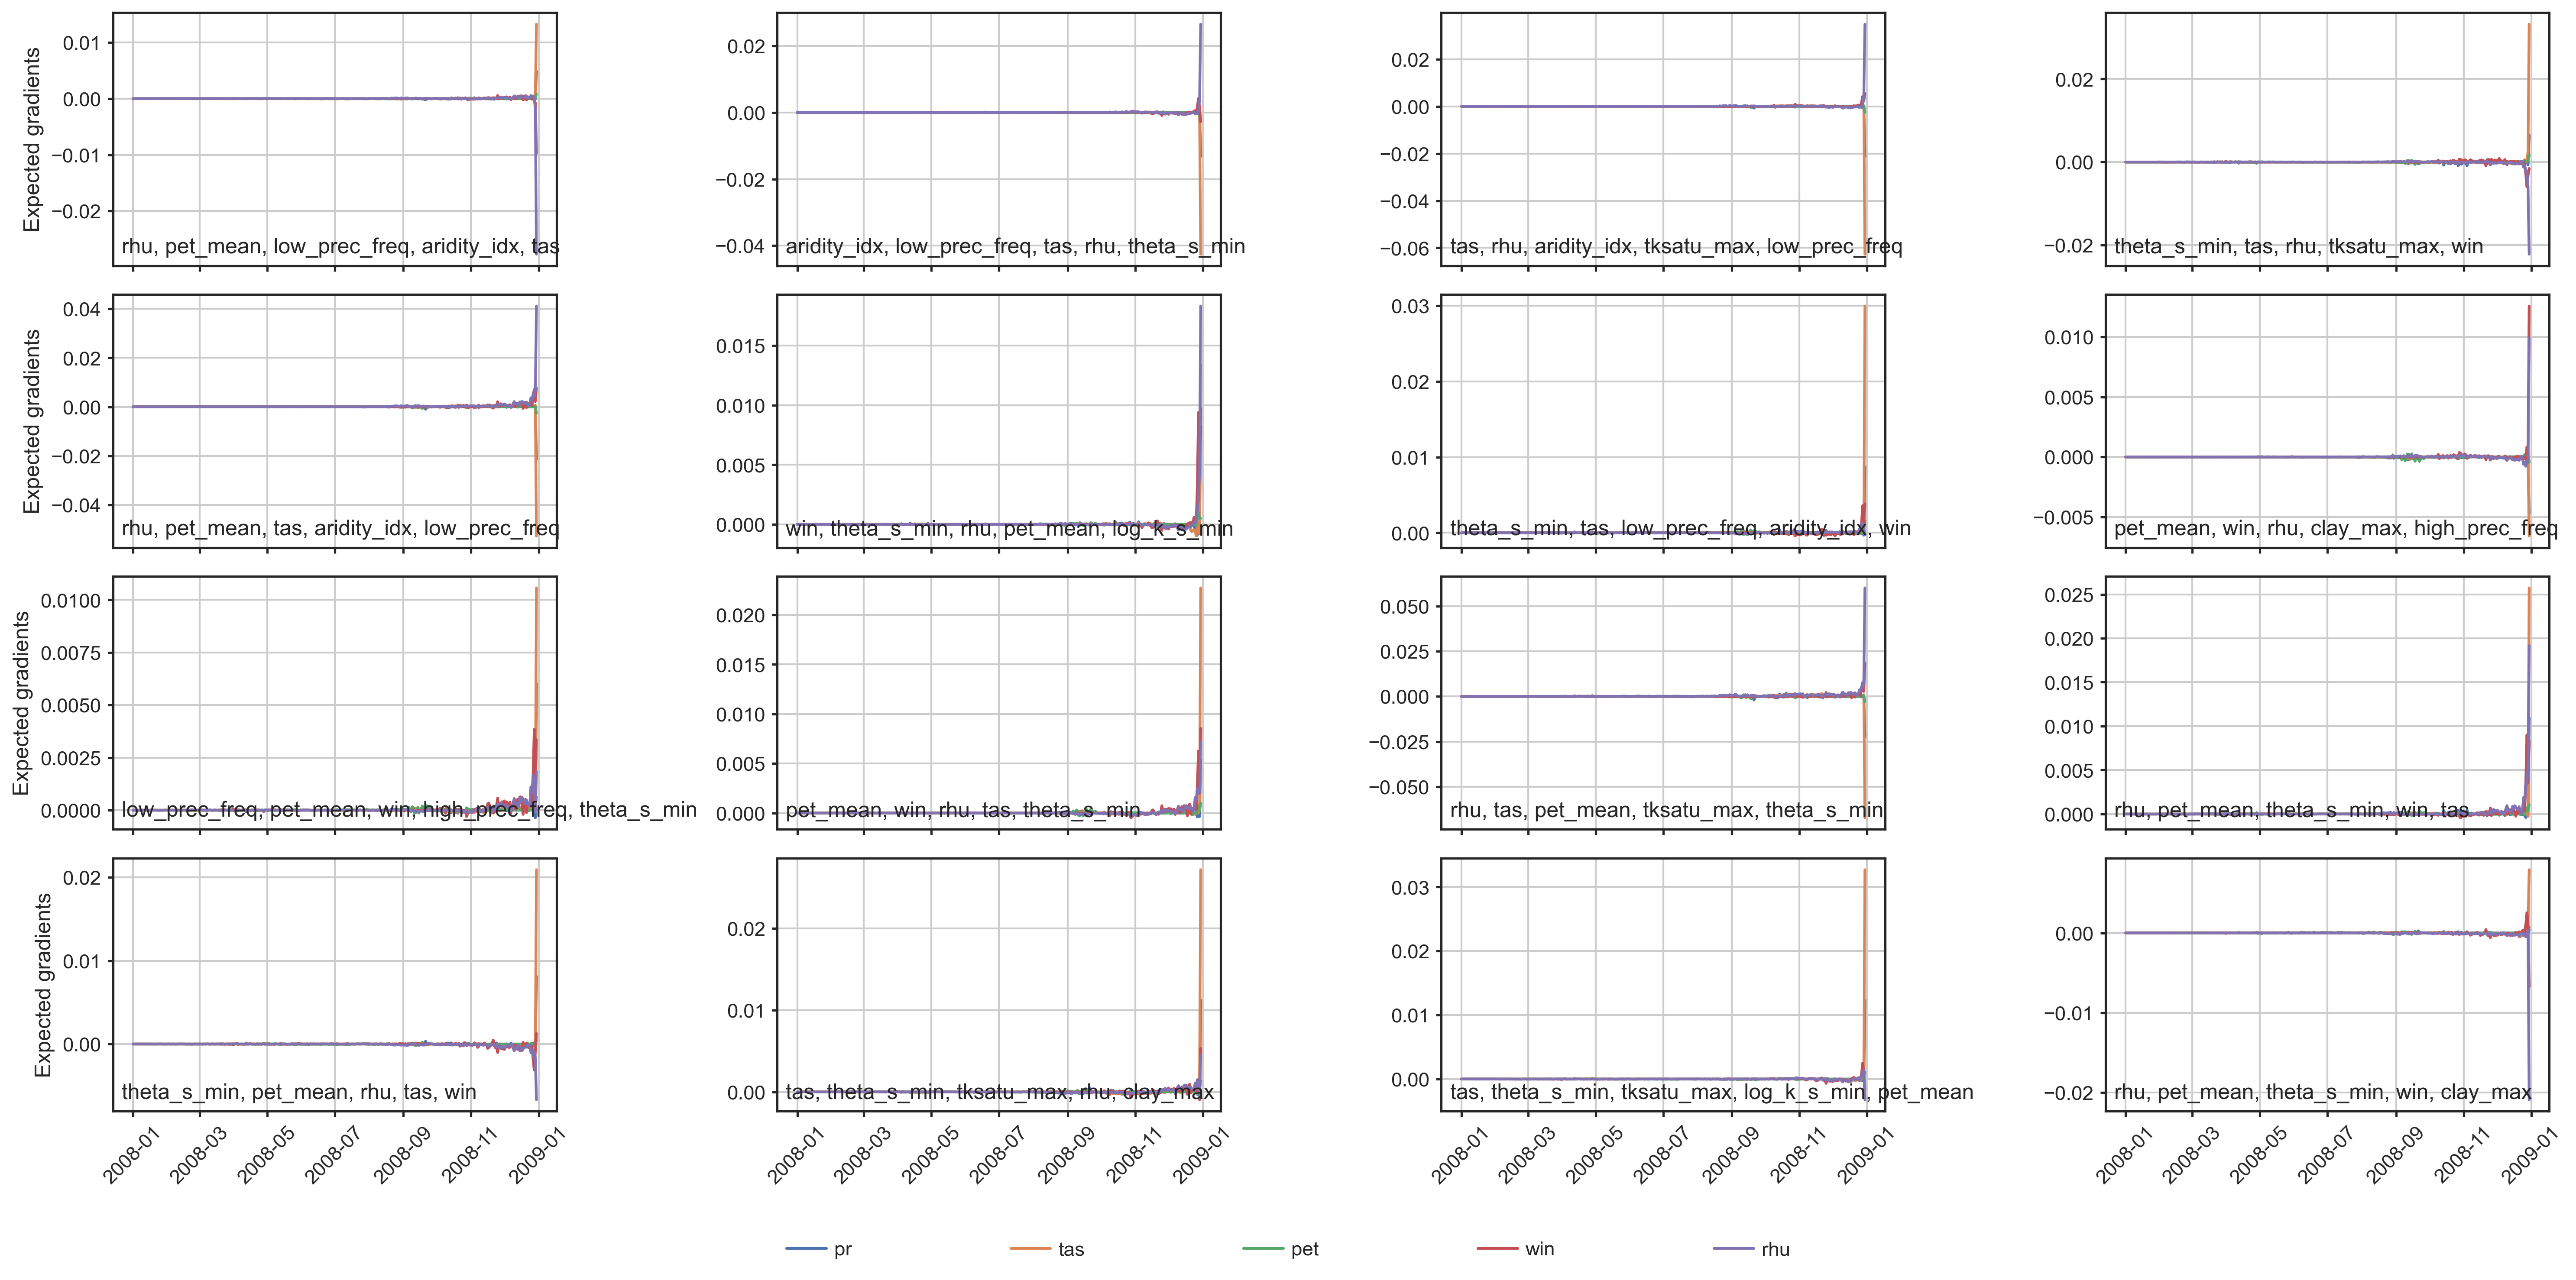

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10), dpi=300)
axes = axes.flatten()

for mul in range(0, nMul):
    eg = shap_values[dyn_paras.index(para) + len(dyn_paras) * mul]

    idx = 365  # window of back sight
    # calculate the cumulative absolute ig during the back sight window
    eg_window = np.abs(eg[0, -idx:]).sum(axis=0) # sub-basin 0
    var_5 = np.array(varLst)[np.argsort(eg_window)[::-1][:5]]
    # print(f'The most important 5 variables for component {mul+1} are {var_5}')

    ax = axes[mul]
    for i in range(0, 5):
        ax.plot(dates[-idx:], eg[0, -idx:, i], label=loader.dataTst['forVarLst'][i])
    if mul % 4 == 0:
        ax.set_ylabel('Expected gradients')
    if mul < 12:
        ax.set_xticklabels([])

    ax.tick_params(rotation=45, axis='x')
    ax.grid(True)
    text = ''
    for var in var_5:
        text += f'{var}, '
    ax.annotate(text[:-2], xy=(0.02, 0.05), xycoords='axes fraction')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels=labels, ncol=5, handletextpad=0.4, bbox_to_anchor=(0.3, 0.03, 0.4, 0.02), mode='expand', columnspacing=1, frameon=False)

fig.tight_layout(rect=(0, 0.06, 1, 1))
plt.show()